# <center> ML-7. Прогнозирование биологического ответа (HW-3)

Наша практика будет основана на соревновании Kaggle: [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (Прогнозирование биологического ответа).

*Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).*

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

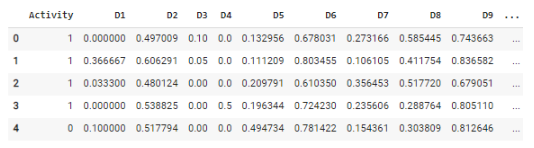

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать **F1-score**.

Необходимо обучить две модели: **логистическую регрессию** и **случайный лес**. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода **(GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna)** хотя бы по разу, максимальное количество итераций не должно превышать **50**.


In [1]:
# Импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных

from sklearn import linear_model # линейные модели
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn.model_selection import train_test_split # разделение выборки
from sklearn.model_selection import cross_val_score

# Импорт базовых и продвинутых методов оптимизации для подбора гиперпараметров
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

# Импорт библиотек для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
plt.style.use('seaborn')

/tmp/ipykernel_16042/47305762.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
data = pd.read_csv('data/_train_sem09 (1).csv')

In [3]:
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.isnull().sum()

Activity    0
D1          0
D2          0
D3          0
D4          0
           ..
D1772       0
D1773       0
D1774       0
D1775       0
D1776       0
Length: 1777, dtype: int64

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [5]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

#### <center> **1. Логистическая регрессия**

In [7]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 50)
# Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*Значение метрики $f_1$ на тестовых данных: 0,79.*

##### ***1.1 GridSearchCV***

1. Подбор оптимальных параметры с помощью поиска по сетке, GridSearchCV:

In [87]:
param_grid = [
              {'penalty': ['l2', 'none'], # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

CPU times: user 1.53 s, sys: 373 ms, total: 1.91 s
Wall time: 2min 50s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


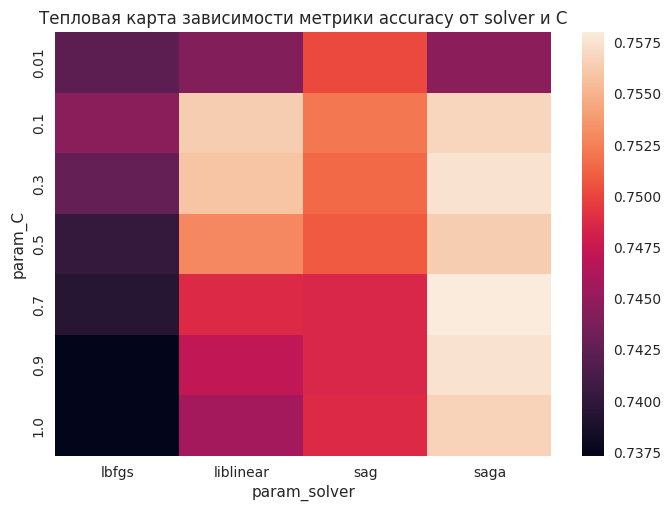

In [88]:
# Посмотрим, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

*Значение метрики $f_1$ на тестовых данных: 0,79. Видно, что слабая регуляризация при С=0,01, отрицательно влияет на метрику, поэтому исключим это значение при дальнейшем подборе гиперпараметров, также алгоритмы оптимизации liblinear и saga работают лучше, что также учтём при подборе.*

Подберем гиперпараметры с помощью метода RandomizedSearchCV.

##### ***1.2 RandomizedSearchCV***

In [89]:
param_distributions = {'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.1, 1, 10, dtype=float))}


random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)

%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_)) 

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:35

CPU times: user 3.28 s, sys: 51.3 ms, total: 3.33 s
Wall time: 30.9 s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.2}


/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


*Значение метрики $f_1$ на тестовых данных стало немного ниже, 0,78.*

Подберём гиперпараметры модели с помощью продвинутых методов оптимизации.

##### ***1.3 HYPEROPT***

In [61]:
# Зададим пространство поиска гиперпараметров
space={'penalty': hp.choice(label='penalty', options=['l1','l2']),
       'solver': hp.choice(label='solver', options=['liblinear', 'saga']),
       'C': hp.uniform('C', 0.1, 1)
      }

In [94]:
# Зафиксируем random_state
random_state = 42

def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # Функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': float(params['C'])
              }
  
    # Используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # Обучаем модель
    model.fit(X, y)
    
    #score = metrics.f1_score(y, model.predict(X))
    
    # Применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # Метрику необходимо максимизировать, поэтому ставим знак минус
    return -score

In [95]:
%%time
# Начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          #rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(hyperopt.space_eval(space, best)))

  5%|▌         | 1/20 [00:03<01:14,  3.90s/trial, best loss: -0.7712221383644842]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 10%|█         | 2/20 [00:35<05:59, 19.99s/trial, best loss: -0.7789250000986646]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 15%|█▌        | 3/20 [00:36<03:11, 11.27s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 20%|██        | 4/20 [01:02<04:37, 17.32s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 25%|██▌       | 5/20 [01:04<02:55, 11.68s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 30%|███       | 6/20 [01:23<03:21, 14.39s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:3

 35%|███▌      | 7/20 [01:43<03:30, 16.20s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 45%|████▌     | 9/20 [01:49<01:39,  9.08s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 50%|█████     | 10/20 [02:18<02:32, 15.30s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 55%|█████▌    | 11/20 [02:19<01:37, 10.86s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 60%|██████    | 12/20 [02:39<01:48, 13.57s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 65%|██████▌   | 13/20 [02:42<01:11, 10.28s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 70%|███████   | 14/20 [03:10<01:34, 15.67s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:3

 75%|███████▌  | 15/20 [03:42<01:43, 20.66s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 80%|████████  | 16/20 [03:44<01:00, 15.13s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 85%|████████▌ | 17/20 [04:02<00:48, 16.04s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:3

 90%|█████████ | 18/20 [04:26<00:36, 18.17s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:3

 95%|█████████▌| 19/20 [04:55<00:21, 21.64s/trial, best loss: -0.7832526734592273]

/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 20/20 [04:58<00:00, 14.95s/trial, best loss: -0.7832526734592273]
Наилучшие значения гиперпараметров {'C': 0.1662949229054717, 'penalty': 'l1', 'solver': 'liblinear'}
CPU times: user 1min 40s, sys: 913 ms, total: 1min 41s
Wall time: 4min 58s


In [97]:
# Рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=hyperopt.space_eval(space, best)['penalty'],
    solver=hyperopt.space_eval(space, best)['solver'],
    C=float(best['C']),
    max_iter=50
)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


*Значение метрики $f_1$ на тестовых данных осталось прежним, 0,78.*

Подберём гиперпараметры модели с помощью метода OPTUNA.

##### ***1.4 OPTUNA***

In [98]:
def optuna_lr(trial):
  # Задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1','l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', 0.1, 1, step=0.1,log=False)

  # Создаем модель
  model = linear_model.LogisticRegression(random_state=random_state,
                                          penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          max_iter=50
                                          )
  # Обучаем модель
  model.fit(X_train, y_train)
  
  # Применим  cross validation с тем же количеством фолдов
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
  #score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [99]:
%%time
# Создаем объект исследования
# Можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=20)

[I 2023-07-11 19:52:17,190] A new study created in memory with name: LogisticRegression
[I 2023-07-11 19:52:19,606] Trial 0 finished with value: 0.7862720943037511 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.4}. Best is trial 0 with value: 0.7862720943037511.
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

CPU times: user 56.7 s, sys: 910 ms, total: 57.6 s
Wall time: 3min 19s


In [101]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.4}
f1_score на обучающем наборе: 0.79


In [102]:
# Рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


/home/andrey/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


*Значение метрики $f_1$ на тестовых данных немного улучшилось, стало равным 0,79.*

Проделаем аналогичный подбор гиперпараметров для модели RandomForestClassifier().

#### <center>**2. Случайный лес**

In [9]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.81


*Значение метрики $f_1$ на тестовых данных в результате обучения модели случайный лес улучшилось, стало равным 0,81.*

##### ***2.1 GridSearchCV***

Подберём оптимальные параметры с помощью поиска по сетке, GridSearchCV:

In [90]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': list(np.linspace(3, 7, 1, dtype=int)),
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: user 1.97 s, sys: 63.6 ms, total: 2.04 s
Wall time: 59.8 s
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 110}


*Значение метрики $f_1$ на тестовых - 0,83.* 

Подберем гиперпараметры с помощью метода RandomizedSearchCV. Изменим диапазон параметра max_depth, учитывая предыдущие результаты.

##### ***2.2 RandomizedSearchCV***

In [92]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': list(np.linspace(3, 7, 1, dtype=int)),
              'max_depth': list(np.linspace(10, 30, 5, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 1.99 s, sys: 116 ms, total: 2.11 s
Wall time: 29.5 s
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 3, 'max_depth': 20}


*Значение метрики $f_1$ на тестовых данных не изменилось, метод подобрал те же значения параметров, что и GridSearchCV.*

Подберём гиперпараметры модели с помощью продвинутых методов оптимизации.

##### ***2.3 HYPEROPT***

In [107]:
# Зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 80, 200, 1),
       'max_depth': hp.quniform('max_depth', 10, 30, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [108]:
# Зафиксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # Функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # Используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # Обучаем модель
    model.fit(X, y)
    
    #score = metrics.f1_score(y, model.predict(X))
    
    # Применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # Метрику необходимо максимизировать, поэтому ставим знак минус
    return -score

In [109]:
%%time
# Начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          #rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(hyperopt.space_eval(space, best)))

100%|██████████| 20/20 [02:00<00:00,  6.05s/trial, best loss: -0.8100116252181717]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 98.0}
CPU times: user 40.2 s, sys: 648 ms, total: 40.9 s
Wall time: 2min


In [110]:
# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


*Метрика немного ухудшилась.*

Подберём гиперпараметры модели с помощью метода OPTUNA.

##### ***2.4 OPTUNA***

In [111]:
def optuna_rf(trial):
  # Задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 80, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # Создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # Обучаем модель
  model.fit(X_train, y_train)
 
  
  # Применим  cross validation с тем же количеством фолдов
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
  #score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [112]:
%%time
# Создаем объект исследования
# Можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-07-11 20:20:03,529] A new study created in memory with name: RandomForestClassifier
[I 2023-07-11 20:20:16,078] Trial 0 finished with value: 0.8170538284566204 and parameters: {'n_estimators': 178, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8170538284566204.
[I 2023-07-11 20:20:25,188] Trial 1 finished with value: 0.8103945282702119 and parameters: {'n_estimators': 155, 'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8170538284566204.
[I 2023-07-11 20:20:31,196] Trial 2 finished with value: 0.8050532275870801 and parameters: {'n_estimators': 109, 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8170538284566204.
[I 2023-07-11 20:20:38,564] Trial 3 finished with value: 0.8038009866670095 and parameters: {'n_estimators': 133, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8170538284566204.
[I 2023-07-11 20:20:45,382] Trial 4 finished with value: 0.8007811461464502 and parameters: {'n_

CPU times: user 49.3 s, sys: 884 ms, total: 50.1 s
Wall time: 2min 51s


In [113]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 177, 'max_depth': 23, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


In [114]:
# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


*Метрика не изменилась. Лучшее значение, 0,83, метрика показала при использовании базовых методов подборов гиперпараметров для модели случайного леса. В случае логистической регрессии мы были ограничены числом итераций равных 50, что также влияло на метрику. Но в любом случае, при увеличении числа итераций при тех же параметрах, больше 0,8 метрика не поднималась.*